# Predict Salary

In [3]:
import glassdoor_scraper as gs
import pandas as pd
import requests
import io


In [ ]:
#path="/home/chris/Documents/Code/data-science/practice/predict-salary/chromedriver"

#df=gs.get_jobs('data scientist', 15, False, path, 15)
url="https://raw.githubusercontent.com/PlayingNumbers/ds_salary_proj/master/glassdoor_jobs.csv"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))
#df.to_csv('glassdoor_jobs.csv',index=False)

## Data Cleaning

In [194]:
df=pd.read_csv('glassdoor_jobs.csv')
df.describe()

,Unnamed: 0,Rating,Founded
count,956.000000,956.000000,956.000000
mean,477.500000,3.601255,1774.605649
std,276.117729,1.067619,598.942517
min,0.000000,-1.000000,-1.000000
25%,238.750000,3.300000,1937.000000
50%,477.500000,3.800000,1992.000000
75%,716.250000,4.200000,2008.000000
max,955.000000,5.000000,2019.000000


### Salary Parsing

In [195]:
df=df[df['Salary Estimate']!='-1']
df.describe()

,Unnamed: 0,Rating,Founded
count,742.000000,742.000000,742.000000
mean,469.129380,3.618868,1837.154987
std,279.793117,0.801210,497.183763
min,0.000000,-1.000000,-1.000000
25%,221.500000,3.300000,1939.000000
50%,472.500000,3.700000,1988.000000
75%,707.750000,4.000000,2007.000000
max,955.000000,5.000000,2019.000000


In [196]:
df['hourly']=df['Salary Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
df['employer_provided']=df['Salary Estimate'].apply(lambda x: 1 if 'employer provided salary:' in x.lower() else 0)


In [197]:
salary=df['Salary Estimate'].apply(lambda x: x.split('(')[0])
minusKd=salary.apply(lambda x: x.replace('K','').replace('$',''))
minHr=minusKd.apply(lambda x: x.lower().replace('per hour','').replace('employer provided salary:',''))
minHr[:50]
df['min_salary']=minHr.apply(lambda x: int(x.split('-')[0]))
df['max_salary']=minHr.apply(lambda x: int(x.split('-')[1]))
df['avg_salary']=(df.min_salary+df.max_salary)/2
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,hourly,employer_provided,min_salary,max_salary,avg_salary
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,0,0,53,91,72.0
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,0,0,63,112,87.5
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,0,0,80,90,85.0
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",0,0,56,97,76.5
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",0,0,86,143,114.5


In [198]:
# Hourly wage to annual
df['min_salary']=df.apply(lambda x: x.min_salary*2 if x.hourly==1 else x.min_salary, axis=1)
df['max_salary']=df.apply(lambda x: x.max_salary*2 if x.hourly==1 else x.max_salary, axis=1)

### Company name text only

In [199]:
df['company_txt']=df.apply(lambda x: x['Company Name'] if x['Rating']<0 else x['Company Name'][:-3], axis=1)
df['company_txt']

0                          Tecolote Research\n
1      University of Maryland Medical System\n
2                                    KnowBe4\n
3                                       PNNL\n
4                         Affinity Solutions\n
                        ...                   
950                                      GSK\n
951                               Eventbrite\n
952           Software Engineering Institute\n
953                             Numeric, LLC\n
955             Riverside Research Institute\n
Name: company_txt, Length: 742, dtype: object

In [200]:
df['company_txt']=df.company_txt.apply(lambda x: x.replace('\n', ''))
df.company_txt

0                          Tecolote Research
1      University of Maryland Medical System
2                                    KnowBe4
3                                       PNNL
4                         Affinity Solutions
                       ...                  
950                                      GSK
951                               Eventbrite
952           Software Engineering Institute
953                             Numeric, LLC
955             Riverside Research Institute
Name: company_txt, Length: 742, dtype: object

### State field

In [201]:
df['job_state']=df['Location'].apply(lambda x: x.split(',')[1])
df['job_state']

0       NM
1       MD
2       FL
3       WA
4       NY
      ... 
950     MA
951     TN
952     PA
953     PA
955     OH
Name: job_state, Length: 742, dtype: object

In [202]:
df['same_state']=df.apply(lambda x: 1 if x.Location==x.Headquarters else 0, axis=1)
#df.same_state

In [203]:
# Fix state Los Angeles
df.job_state=df.job_state.apply(lambda x: x.strip() if x.strip().lower() != 'los angeles' else 'CA')
#df.drop('job_state', inplace=True, axis=1)

### Age of company

In [204]:
df['age']=df.Founded.apply(lambda x: x if x<1 else 2021 - x)
df.age

0       48
1       37
2       11
3       56
4       23
      ... 
950    191
951     15
952     37
953     -1
955     54
Name: age, Length: 742, dtype: int64

### Job Description

In [205]:
df['python_yn']=df['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
df['R_yn']=df['Job Description'].apply(lambda x: 1 if 'r studio' in x.lower() or 'r-studio' in x.lower() else 0)
df['spark_yn']=df['Job Description'].apply(lambda x: 1 if 'spark' in x.lower() else 0)
df['aws_yn']=df['Job Description'].apply(lambda x: 1 if 'aws' in x.lower() else 0)
df.aws_yn.value_counts()
df['excel_yn']=df['Job Description'].apply(lambda x: 1 if 'excel' in x.lower() else 0)

In [206]:
# Job description length
df['desc_len']=df['Job Description'].apply(lambda x: len(x))

### Competitors

In [207]:
df['num_comp']=df['Competitors'].apply(lambda x: len(x.split(',')) if x!= '-1' else 0)

### Job Title

In [208]:

def title_simplifier(title):
    if 'data scientist' in title.lower():
        return 'data scientist'
    elif 'data engineer' in title.lower():
        return 'data engineer'
    elif 'analyst' in title.lower():
        return 'analyst'
    elif 'machine learning' in title.lower():
        return 'mle'
    elif 'manager' in title.lower():
        return 'manager'
    elif 'director' in title.lower():
        return 'director'
    else:
        return 'na'
    
def seniority(title):
    if 'sr' in title.lower() or 'senior' in title.lower() or 'sr' in title.lower() or 'lead' in title.lower() or 'principal' in title.lower():
            return 'senior'
    elif 'jr' in title.lower() or 'jr.' in title.lower():
        return 'jr'
    else:
        return 'na'

In [209]:
df['job_simp']=df['Job Title'].apply(title_simplifier)
df.job_simp.value_counts()

data scientist    279
na                184
data engineer     119
analyst           102
mle                22
manager            22
director           14
Name: job_simp, dtype: int64

In [210]:
df['seniority']=df['Job Title'].apply(seniority)
df.seniority.value_counts()

na        520
senior    220
jr          2
Name: seniority, dtype: int64

### Drop Unnamed: 0 Column

In [211]:
df_out =df.drop(['Unnamed: 0'], axis=1)
df_out

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,age,python_yn,R_yn,spark_yn,aws_yn,excel_yn,desc_len,num_comp,job_simp,seniority
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,...,48,1,0,0,0,1,2536,0,data scientist,na
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,...,37,1,0,0,0,0,4783,0,data scientist,na
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,...,11,1,0,1,0,1,3461,0,data scientist,na
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,...,56,1,0,0,0,0,3883,3,data scientist,na
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,...,23,1,0,0,0,1,2728,3,data scientist,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,"Sr Scientist, Immuno-Oncology - Oncology",$58K-$111K (Glassdoor est.),Site Name: USA - Massachusetts - Cambridge\nPo...,3.9,GSK\n3.9,"Cambridge, MA","Brentford, United Kingdom",10000+ employees,1830,Company - Public,...,191,0,0,0,1,0,6162,3,na,senior
951,Senior Data Engineer,$72K-$133K (Glassdoor est.),THE CHALLENGE\nEventbrite has a world-class da...,4.4,Eventbrite\n4.4,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,2006,Company - Public,...,15,1,0,1,1,0,6130,3,data engineer,senior
952,"Project Scientist - Auton Lab, Robotics Institute",$56K-$91K (Glassdoor est.),The Auton Lab at Carnegie Mellon University is...,2.6,Software Engineering Institute\n2.6,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,1984,College / University,...,37,0,0,0,0,1,3078,0,na,na
953,Data Science Manager,$95K-$160K (Glassdoor est.),Data Science ManagerResponsibilities:\n\nOvers...,3.2,"Numeric, LLC\n3.2","Allentown, PA","Chadds Ford, PA",1 to 50 employees,-1,Company - Private,...,-1,0,0,0,0,1,1642,0,manager,na


### Export Data cleaned

In [212]:
df_out.to_csv('salary_data_cleaned.csv', index=False)

## Exploratory Data Analysis

In [4]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [5]:
df=pd.read_csv('salary_data_cleaned.csv')

In [6]:
df.describe()

,Rating,Founded,hourly,employer_provided,min_salary,max_salary,avg_salary,same_state,age,python_yn,R_yn,spark_yn,aws_yn,excel_yn,desc_len,num_comp
count,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,3.618868,1837.154987,0.032345,0.022911,74.719677,128.149596,100.626011,0.557951,47.524259,0.528302,0.002695,0.225067,0.237197,0.522911,3869.545822,1.053908
std,0.801210,497.183763,0.177034,0.149721,30.980593,45.220324,38.855948,0.496965,53.839080,0.499535,0.051882,0.417908,0.425651,0.499812,1521.495868,1.384239
min,-1.000000,-1.000000,0.000000,0.000000,15.000000,16.000000,13.500000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000
25%,3.300000,1939.000000,0.000000,0.000000,52.000000,96.000000,73.500000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2801.000000,0.000000
50%,3.700000,1988.000000,0.000000,0.000000,69.500000,124.000000,97.500000,1.000000,25.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3731.000000,0.000000
75%,4.000000,2007.000000,0.000000,0.000000,91.000000,155.000000,122.500000,1.000000,60.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4740.000000,3.000000
max,5.000000,2019.000000,1.000000,1.000000,202.000000,306.000000,254.000000,1.000000,277.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10051.000000,4.000000


In [216]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark_yn', 'aws_yn', 'excel_yn', 'desc_len', 'num_comp', 'job_simp',
       'seniority'],
      dtype='object')

<AxesSubplot:>

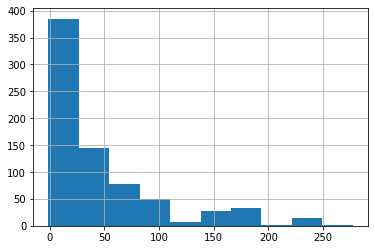

In [217]:
df.age.hist()

<AxesSubplot:>

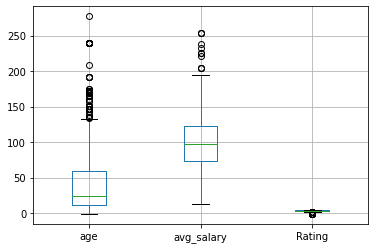

In [218]:
df.boxplot(column=['age','avg_salary','Rating'])

<AxesSubplot:>

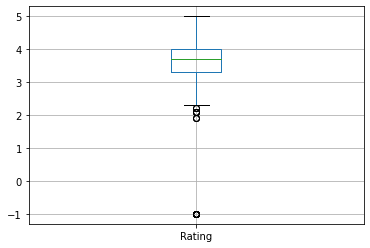

In [219]:
df.boxplot(column=['Rating'])

In [220]:
df[['age','avg_salary','Rating','desc_len']].corr()

,age,avg_salary,Rating,desc_len
age,1.000000,0.019574,0.023162,0.164188
avg_salary,0.019574,1.000000,0.013492,0.078808
Rating,0.023162,0.013492,1.000000,-0.012281
desc_len,0.164188,0.078808,-0.012281,1.000000


<AxesSubplot:>

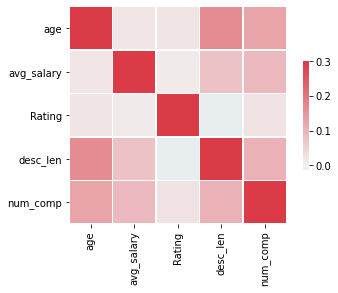

In [7]:
cmap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(df[['age','avg_salary','Rating','desc_len','num_comp']].corr(),vmax=.3,center=0,square=True,cmap=cmap,linewidth=.5,cbar_kws={"shrink":.5})

In [222]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark_yn', 'aws_yn', 'excel_yn', 'desc_len', 'num_comp', 'job_simp',
       'seniority'],
      dtype='object')

In [8]:
dfCat=df[['Location', 'Headquarters', 'Size','Type of ownership', 'Industry', 'Sector', 'Revenue','company_txt','job_state','same_state','python_yn', 'R_yn', 'spark_yn',
       'aws_yn', 'excel_yn','job_simp', 'seniority']]

graph for Location: total= 20


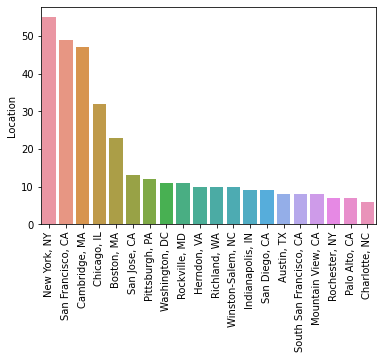

graph for Headquarters: total= 20


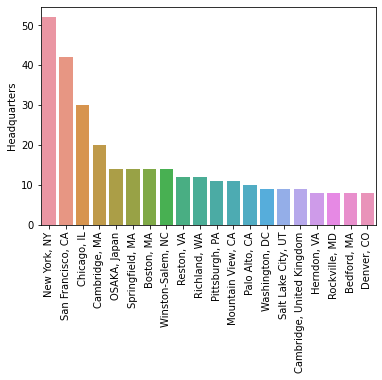

graph for company_txt: total= 20


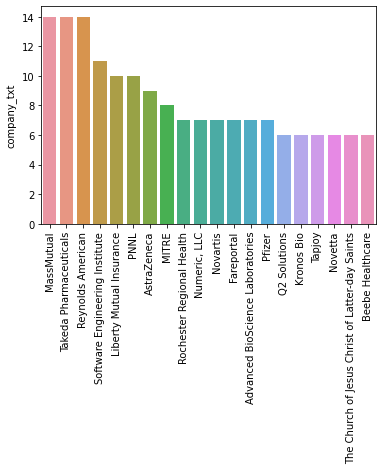

In [9]:
for i in dfCat[['Location','Headquarters','company_txt']]:
    catNum=dfCat[i].value_counts()[:20]
    print("graph for %s: total= %d" % (i,len(catNum)))
    chart=sns.barplot(x=catNum.index, y=catNum)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()

In [10]:
pd.pivot_table(df, index='job_simp', values='avg_salary')

,avg_salary
job_simp,
analyst,65.857843
data engineer,105.403361
data scientist,117.564516
director,168.607143
manager,84.022727
mle,126.431818
na,84.853261


In [11]:
pd.pivot_table(df, index=['job_simp','seniority'], values='avg_salary')

avg_salary
job_simp       seniority            
analyst        jr          56.500000
               na          61.155405
               senior      79.092593
data engineer  na          96.701220
               senior     124.689189
data scientist jr         106.500000
               na         107.043011
               senior     138.956522
director       na         168.607143
manager        na          84.022727
mle            na         119.133333
               senior     142.071429
na             na          73.988189
               senior     109.061404

In [19]:
pd.set_option('display.max_rows',10)
pd.pivot_table(df, index=['job_state','job_simp'], values='avg_salary',aggfunc='count').sort_values('job_state',ascending=False)

avg_salary
job_state job_simp                  
WI        na                       4
          data scientist           3
          analyst                  3
WA        na                       1
          data scientist          17
...                              ...
AZ        analyst                  1
          na                       2
AL        na                       2
          data engineer            1
          analyst                  5

[114 rows x 1 columns]

In [21]:
pd.pivot_table(df[df.job_simp=='data scientist'], index=['job_state'], values='avg_salary').sort_values('avg_salary',ascending=False)

,avg_salary
job_state,
DC,149.000000
CA,142.522059
UT,140.500000
MO,127.666667
IL,117.233333
...,...
KY,84.000000
CT,84.000000
GA,81.333333


In [28]:
df_pivots = df[['Rating', 'Industry', 'Sector', 'Revenue', 'num_comp', 'hourly', 'employer_provided', 'python_yn', 'R_yn', 'spark_yn', 'aws_yn', 'excel_yn', 'Type of ownership','avg_salary']]
for i in df_pivots.columns:
    print(pd.pivot_table(df_pivots,index=i, values='avg_salary').sort_values('avg_salary',ascending=False))

        avg_salary
Rating            
-1.0    136.181818
 5.0    134.700000
 2.5    120.000000
 4.5    117.714286
 4.1    116.368421
...            ...
 2.7     83.250000
 2.3     81.500000
 2.9     81.138889
 4.8     80.277778
 2.4     60.214286

[31 rows x 1 columns]
                                          avg_salary
Industry                                            
Other Retail Stores                       163.500000
Motion Picture Production & Distribution  146.000000
Financial Analytics & Research            145.125000
Health, Beauty, & Fitness                 139.500000
Telecommunications Services               131.500000
...                                              ...
Architectural & Engineering Services       50.500000
Gambling                                   48.500000
Social Assistance                          48.166667
Telecommunications Manufacturing           44.000000
Construction                               26.500000

[60 rows x 1 columns]
                  

ValueError: Grouper for 'avg_salary' not 1-dimensional

In [30]:
pd.pivot_table(df_pivots, index='Revenue', columns='python_yn',values='avg_salary', aggfunc='count')

python_yn,0,1
Revenue,,
$1 to $2 billion (USD),16.0,44.0
$1 to $5 million (USD),1.0,7.0
$10 to $25 million (USD),16.0,16.0
$10+ billion (USD),66.0,58.0
$100 to $500 million (USD),47.0,44.0
...,...,...
$50 to $100 million (USD),21.0,25.0
$500 million to $1 billion (USD),29.0,28.0
-1,1.0,NaN
